In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import pickle


In [5]:
adnifulldf = pd.read_csv("../Dataset/ADNI/adnitable.csv")

In [8]:
# adnifulldf.Gender = adnifulldf.Gender.apply(lambda x: 'M' if x==1 else 'F')
adnifulldf = adnifulldf.fillna(-1)
adnifulldf.DX = adnifulldf.DX.apply(lambda x: 'CN' if x==1 else ('MCI' if x==2 else ('AD' if x==3 else -1)))

In [9]:
adnifulldf.head()

,RID,Gender,Educ,Age,APOE,MMSE,DX,mri_001,mri_002,mri_003,...,fdg_05,amyloid_01,amyloid_02,amyloid_03,amyloid_04,amyloid_05,amyloid_06,csf_01,csf_02,csf_03
0,1,2,18.0,61.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
1,1,2,18.0,61.25,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
2,1,2,18.0,61.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
3,1,2,18.0,62.00,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0
4,1,2,18.0,62.50,-1,-1.0,-1,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1,-1.0,-1.0,-1.0


In [150]:
mri_vars = [fieldname for fieldname in adnifulldf.columns if 'mri_' in fieldname]
amyloid_vars = [fieldname for fieldname in adnifulldf.columns if 'amyloid_' in fieldname]
csf_vars = [fieldname for fieldname in adnifulldf.columns if 'csf_' in fieldname]
fdg_vars = [fieldname for fieldname in adnifulldf.columns if 'fdg_' in fieldname]
pet_vars = [fieldname for fieldname in adnifulldf.columns if 'pet_' in fieldname]
factors = ['RID','Gender','Educ','Age','APOE','MMSE','DX']
dx_stages = ['CN', 'AD']

mridf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["mri_001"] != -1), factors+mri_vars]
amyloiddf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["amyloid_01"] != -1), factors+amyloid_vars]
csfdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["csf_01"] != -1), factors+csf_vars]
fdgdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["fdg_01"] != -1), factors+fdg_vars]
petdf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["Educ"] != -1) & (adnifulldf["pet_01"] != -1), factors+pet_vars]

In [11]:
petdf.DX.value_counts()

CN    594
AD    530
Name: DX, dtype: int64

/home/ksaboo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


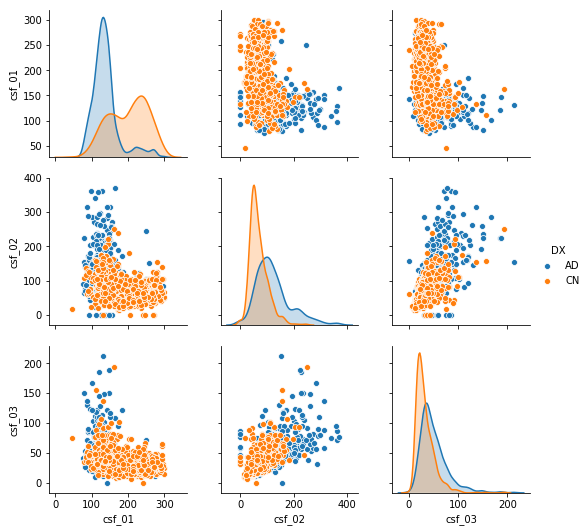

In [12]:
sns.pairplot(csfdf, hue="DX", vars=csf_vars, diag_kind='kde', diag_kws=dict(shade=True))
plt.show()

In [13]:
print(len(mridf), len(amyloiddf), len(csfdf), len(fdgdf), len(petdf))

3797 1116 1170 1789 1124


In [151]:
print(len(mridf), len(amyloiddf), len(csfdf), len(fdgdf), len(petdf))

3797 1116 1170 1789 1124


# Different classifiers for each data modality

## Amyloid

In [19]:
# prepare data with appropriate features and randomization
shuffled_df = amyloiddf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age'], amyloid_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=4)
# mlmodel = SVC(C=1e1, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=4)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
predicted_Y = mlmodel.predict(testing_X)
confmat_test = confusion_matrix(testing_Y,predicted_Y)
sensitivity_test = 100*confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) # TP/(FN+TP)
specificity_test = 100*confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) # TN/(TN+FP)
# test model - training data
confmat_train = confusion_matrix(training_Y,mlmodel.predict(training_X))
sensitivity_train = 100*confmat_train[1,1]/(confmat_train[1,0]+confmat_train[1,1]) # TP/(FN+TP)
specificity_train = 100*confmat_train[0,0]/(confmat_train[0,0]+confmat_train[0,1]) # TN/(TN+FP)

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 72.46, Specificity: 81.17
Train: Sensitivity = 78.67, Specificity: 89.95


## FDG

In [140]:
## prepare data with appropriate features and randomization
shuffled_df = fdgdf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age'], fdg_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=4)
# mlmodel = SVC(C=1e0, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=4)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
predicted_Y = mlmodel.predict(testing_X)
confmat_test = confusion_matrix(testing_Y,predicted_Y)
sensitivity_test = 100*confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) # TP/(FN+TP)
specificity_test = 100*confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) # TN/(TN+FP)
# test model - training data
confmat_train = confusion_matrix(training_Y,mlmodel.predict(training_X))
sensitivity_train = 100*confmat_train[1,1]/(confmat_train[1,0]+confmat_train[1,1]) # TP/(FN+TP)
specificity_train = 100*confmat_train[0,0]/(confmat_train[0,0]+confmat_train[0,1]) # TN/(TN+FP)

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 75.76, Specificity: 87.56
Train: Sensitivity = 85.59, Specificity: 89.57


## CSF

In [154]:
## prepare data with appropriate features and randomization
shuffled_df = csfdf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age'], csf_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=5)
# mlmodel = SVC(C=1e1, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=5)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
predicted_Y = mlmodel.predict(testing_X)
confmat_test = confusion_matrix(testing_Y,predicted_Y)
sensitivity_test = 100*confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) # TP/(FN+TP)
specificity_test = 100*confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) # TN/(TN+FP)
# test model - training data
confmat_train = confusion_matrix(training_Y,mlmodel.predict(training_X))
sensitivity_train = 100*confmat_train[1,1]/(confmat_train[1,0]+confmat_train[1,1]) # TP/(FN+TP)
specificity_train = 100*confmat_train[0,0]/(confmat_train[0,0]+confmat_train[0,1]) # TN/(TN+FP)

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 84.00, Specificity: 81.34
Train: Sensitivity = 85.50, Specificity: 83.61


## PET

In [181]:
## prepare data with appropriate features and randomization
shuffled_df = petdf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age'], pet_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=5)
# mlmodel = SVC(C=1e-1, kernel='linear')
mlmodel = RandomForestClassifier(n_estimators=10, max_depth=5)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
predicted_Y = mlmodel.predict(testing_X)
confmat_test = confusion_matrix(testing_Y,predicted_Y)
sensitivity_test = 100*confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) # TP/(FN+TP)
specificity_test = 100*confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) # TN/(TN+FP)
# test model - training data
confmat_train = confusion_matrix(training_Y,mlmodel.predict(training_X))
sensitivity_train = 100*confmat_train[1,1]/(confmat_train[1,0]+confmat_train[1,1]) # TP/(FN+TP)
specificity_train = 100*confmat_train[0,0]/(confmat_train[0,0]+confmat_train[0,1]) # TN/(TN+FP)

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 50.52, Specificity: 82.81
Train: Sensitivity = 58.89, Specificity: 84.98


## MRI

In [188]:
## prepare data with appropriate features and randomization
shuffled_df = mridf.sample(frac=1, random_state=1)
features = [item for sublist in [['Gender','Educ','Age'], mri_vars] for item in sublist]
data_X = shuffled_df[features].values.reshape(-1,len(features))
data_Y = np.where(shuffled_df["DX"] == "CN", 0, 1) # if CN: 0, if AD: 1

# prepare training and test data
train_frac = 0.8
num_samples = np.shape(data_X)[0]
num_samples_train = int(np.round(num_samples*train_frac))

training_X = data_X[:num_samples_train,:]
training_Y = data_Y[:num_samples_train]
testing_X = data_X[num_samples_train:,:]
testing_Y = data_Y[num_samples_train:]

from sklearn.linear_model import LogisticRegressionCV
# from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# select model
# mlmodel = LogisticRegressionCV(Cs=20, cv=5)
mlmodel = SVC(C=1e0, kernel='linear')
# mlmodel = RandomForestClassifier(n_estimators=10, max_depth=5)

# train model
mlmodel.fit(training_X, training_Y)

# test model - test data
predicted_Y = mlmodel.predict(testing_X)
confmat_test = confusion_matrix(testing_Y,predicted_Y)
sensitivity_test = 100*confmat_test[1,1]/(confmat_test[1,0]+confmat_test[1,1]) # TP/(FN+TP)
specificity_test = 100*confmat_test[0,0]/(confmat_test[0,0]+confmat_test[0,1]) # TN/(TN+FP)
# test model - training data
confmat_train = confusion_matrix(training_Y,mlmodel.predict(training_X))
sensitivity_train = 100*confmat_train[1,1]/(confmat_train[1,0]+confmat_train[1,1]) # TP/(FN+TP)
specificity_train = 100*confmat_train[0,0]/(confmat_train[0,0]+confmat_train[0,1]) # TN/(TN+FP)

print("Test: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_test, specificity_test))
print("Train: Sensitivity = %.2f, Specificity: %.2f" % (sensitivity_train, specificity_train))

Test: Sensitivity = 85.49, Specificity: 93.44
Train: Sensitivity = 86.98, Specificity: 93.83



## Grid Search for Amyloid

In [172]:
clf_list = ['logistic_regression','svm','random_forest']
svc_param_grid = {'C':np.logspace(-2,2,5), 'kernel':['linear'], 'degree':[2], 'gamma':[0.1, 1, 10]}
rf_param_grid = {'n_estimators':np.arange(10,21,dtype=int), 'max_depth':np.arange(3,7,dtype=int)}
clf_to_param_dict = {'logistic_regression':20, 'svm':svc_param_grid, 'random_forest':rf_param_grid}
gs_num_cv = 4
outer_num_cv = 5 # NOTE CHANGE THIS TO 10
save_dir_path = '../Dataset/ProcessedFiles/'

modality_list = ['amyloid','csf','fdg','pet']
factors = ['Gender','Educ','Age','APOE']
clinical_vars = ['Gender','Educ','Age','APOE','MMSE','DX']
dx_stages = ['CN', 'AD']

for modality in ['amyloid','csf']:
    print("Data modality is: " + modality)
    modality_vars = [fieldname for fieldname in adnifulldf.columns if modality in fieldname] 
    modalitydf = adnifulldf.loc[(adnifulldf["DX"].isin(dx_stages)) & (adnifulldf["APOE"] != -1) 
                                & (adnifulldf[modality+'_01'] != -1), clinical_vars+modality_vars].copy()
    modalitydf['DX_bin'] = np.where(modalitydf["DX"]=="CN", 0, 1) # CN:0 , AD: 1

    for include_factors in [0,1]:
        if include_factors == 0: # do not include 'factors' in the features
            features = modality_vars
            save_fname = save_dir_path + clf_name +'_'+ modality+'_cv.pckl'
        else: # include "factors" on the features
            features = [item for sublist in [factors, modality_vars] for item in sublist]
            save_fname = save_dir_path + clf_name +'_'+ modality+'_factors_cv.pckl'
        
        print(features)
        for clf_name in ['logistic_regression']:
            print("Classifier is: " + clf_name)
            grid_out_list = []

            for cvn in range(0, outer_num_cv):
                grid_out = ttSplitWithGridSearch(clf_name, clf_to_param_dict[clf_name], gs_num_cv, 
                                              modalitydf, features, 'DX_bin', train_frac, cvn)
                grid_out_list.append(grid_out)

            pickle.dump(grid_out_list, open(save_fname, 'wb'))

Data modality is: amyloid
['amyloid_01', 'amyloid_02', 'amyloid_03', 'amyloid_04', 'amyloid_05', 'amyloid_06']
Classifier is: logistic_regression
['Gender', 'Educ', 'Age', 'APOE', 'amyloid_01', 'amyloid_02', 'amyloid_03', 'amyloid_04', 'amyloid_05', 'amyloid_06']
Classifier is: logistic_regression


/home/ksaboo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Data modality is: csf
['csf_01', 'csf_02', 'csf_03']
Classifier is: logistic_regression
['Gender', 'Educ', 'Age', 'APOE', 'csf_01', 'csf_02', 'csf_03']
Classifier is: logistic_regression


In [142]:
# with open('../Dataset/ProcessedFiles/'+clf_name+'_amyloid_cv.pckl','wb') as handle:
#     pickle.dump(grid_out_list, handle)

with open(,'rb') as handle:
    myout = pickle.load(handle)


5


In [59]:
from sklearn.metrics import confusion_matrix

def SensiSpeci(true_labels, predicted_labels):
    confmat = confusion_matrix(true_labels, predicted_labels)
    sensitivity = 100*confmat[1,1]/(confmat[1,0]+confmat[1,1]) # TP/(FN+TP)
    specificity = 100*confmat[0,0]/(confmat[0,0]+confmat[0,1]) # TN/(TN+FP)
    return sensitivity, specificity


In [173]:
def gridSearchWrapper(classifier_name, paramdict, num_cv, train_X, train_Y, test_X, test_Y):

    # select and train the model
    if classifier_name.lower() == 'logistic_regression':
        mlmodel = LogisticRegressionCV(Cs=paramdict, cv=num_cv, max_iter=500)
        mlmodel.fit(train_X, train_Y)
    
    elif classifier_name.lower() == 'svm':
        grid_classifier = GridSearchCV(estimator=SVC(), 
                                       param_grid=paramdict, cv=num_cv, verbose=1)
        # train model
        grid_classifier.fit(train_X, train_Y)
        mlmodel = grid_classifier.best_estimator_ # select best model
        
    elif classifier_name.lower() == 'random_forest':
        # grid search for finding best hyper parameters        
        grid_classifier = GridSearchCV(estimator=RandomForestClassifier(),
                                       param_grid=paramdict, cv=num_cv, verbose=1)
        # train model
        grid_classifier.fit(train_X, train_Y)
        mlmodel = grid_classifier.best_estimator_ # select best model
        
    else:
        print("Method not found")
        return 0
    
    # test model - test data
    sensitivity_test, specificity_test = SensiSpeci(test_Y, mlmodel.predict(test_X))
    accuracy_test = 100*mlmodel.score(test_X, test_Y)
    f1_test = f1_score(test_Y, mlmodel.predict(test_X))
    
    # test model - training data
    sensitivity_train, specificity_train = SensiSpeci(train_Y, mlmodel.predict(train_X))
    accuracy_train = 100*mlmodel.score(train_X, train_Y)
    f1_train = f1_score(train_Y, mlmodel.predict(train_X))
    
    # prepare dict to return
    test_score_dict = {'sensitivity':sensitivity_test, 'specificity':specificity_test, 'accuracy':accuracy_test, 'f1':f1_test}
    train_score_dict = {'sensitivity':sensitivity_train, 'specificity':specificity_train, 'accuracy':accuracy_train, 'f1':f1_train}
    
    return {'model': mlmodel, 'test_score':test_score_dict, 'train_score':train_score_dict}

In [134]:
def ttSplitWithGridSearch(classifier_name, paramdict, num_cv, datadf, feature_name, label_name, train_fraction, random_seed):
    # prepare training and test data with appropriate features and randomization
    train_X, test_X, train_Y, test_Y = train_test_split(
        datadf[feature_name], datadf[label_name], train_size=train_fraction, test_size=1-train_fraction,
        random_state=random_seed, shuffle=True)
    
    # preform grid search to choose best model
    grid_search_out = gridSearchWrapper(classifier_name, paramdict, num_cv, 
                              train_X, train_Y, test_X, test_Y)
    
    # return best model and its performance
    return grid_search_out

In [176]:
myout = pickle.load(open('../Dataset/ProcessedFiles/logistic_regression_csf_cv.pckl','rb'))

print([gridout['test_score']['accuracy'] for gridout in myout])

myout = pickle.load(open('../Dataset/ProcessedFiles/logistic_regression_csf_factors_cv.pckl','rb'))

print([gridout['test_score']['accuracy'] for gridout in myout])

[81.62393162393163, 76.49572649572649, 82.90598290598291, 82.05128205128204, 78.63247863247864]
[80.76923076923077, 77.35042735042735, 83.33333333333334, 82.05128205128204, 78.63247863247864]


In [166]:
modalitydf.APOE.value_counts()

0    1035
1      78
Name: APOE, dtype: int64